# Textual Emotion Detection with Hugging Face's Pretrained Model

### Installing transformers and datasets

In [66]:
!pip install transformers
!pip install datasets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Checking total no of datasets available at present

In [67]:
from datasets import list_datasets
all_datasets=list_datasets()
print(f"Total datasets hub: ",len(all_datasets))

Total datasets hub:  123470


In [68]:
all_datasets[:5]

['acronym_identification',
 'ade_corpus_v2',
 'UCLNLP/adversarial_qa',
 'aeslc',
 'afrikaans_ner_corpus']

### Checking if emotion dataset is available or not

In [69]:
'dair-ai/emotion' in all_datasets

True

### Loading the emotion dataset

In [70]:
from datasets import load_dataset
emotion=load_dataset('dair-ai/emotion')

  0%|          | 0/3 [00:00<?, ?it/s]

In [71]:
emotion

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

### Converting to pandas to do some pre-processing and visualization

In [72]:
emotion.set_format(type='pandas')

In [73]:
emotion

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [74]:
emotion['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [75]:
emotion['train'][:]

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


In [76]:
df=emotion['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [77]:
emotion['train'].features['label'].names

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [78]:
classes=emotion['train'].features['label'].names

### Adding label_names as column

In [79]:
df['label_name']=df['label'].apply(lambda x: classes[x])

In [80]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Data Analysis

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

In [82]:
df['label_name'].value_counts()

label_name
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

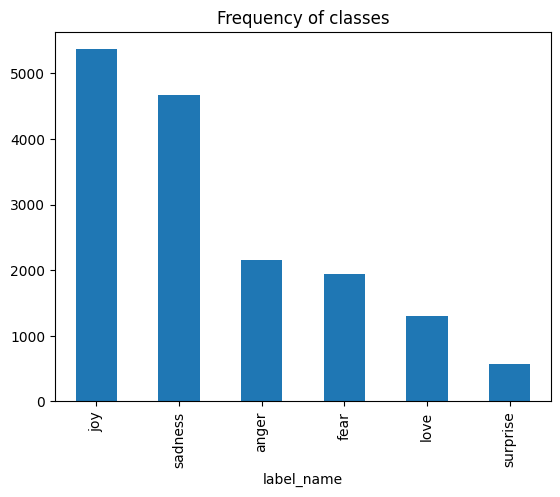

In [84]:
label_counts=df['label_name'].value_counts()
plt.title("Frequency of classes")
label_counts.plot.bar()
plt.show()

In [85]:
df['text'].str.split().apply(len)

0         4
1        21
2        10
3        18
4         4
         ..
15995    24
15996    20
15997     6
15998    14
15999    15
Name: text, Length: 16000, dtype: int64

### Adding words per tweet as a column

In [86]:
df['Words_Per_Tweet']=df['text'].str.split().apply(len)

<Axes: title={'center': 'Words_Per_Tweet'}, xlabel='label_name'>

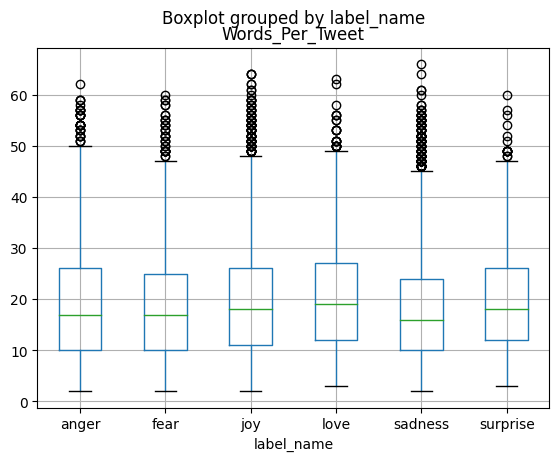

In [87]:
df.boxplot("Words_Per_Tweet",by='label_name')

In [88]:
max(df['text'].str.split().apply(len))

66

### Importing AutoTokenizer and Model

In [89]:
# It will automatically detect the model, and tokenize accordingly
from transformers import AutoTokenizer
model_ckpt="distilbert-base-uncased"  #uncased:will treat capital and small letters same
tokenizer=AutoTokenizer.from_pretrained(model_ckpt)

In [90]:
text="I love Natural Language Processing!.Tokenization is awesome"

In [91]:
tokenizer(text)
# two extra tokens to tell the starting and ending

{'input_ids': [101, 1045, 2293, 3019, 2653, 6364, 999, 1012, 19204, 3989, 2003, 12476, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [92]:
tokenizer.convert_ids_to_tokens(tokenizer(text).input_ids)
# [CLS]
# [SEP]
# also note that it makes I,N,L,P as small letter.

['[CLS]',
 'i',
 'love',
 'natural',
 'language',
 'processing',
 '!',
 '.',
 'token',
 '##ization',
 'is',
 'awesome',
 '[SEP]']

In [93]:
#  ##shows continuation of the previous word.
# basically two parts of a SINGLE token. This approach helps capture the morphological structure of words more effectively.

In [94]:
tokenizer.vocab_size,tokenizer.model_max_length

(30522, 512)

### Tokenization of the Emotion Data set

In [95]:
# resetting back to dataset_dict from pandas
emotion.reset_format()

In [96]:
type(emotion)

datasets.dataset_dict.DatasetDict

### Function to tokenize

In [97]:
# mapping
def tokenize(batch):
    temp=tokenizer(batch['text'],padding=True,truncation=True)
    return temp

In [98]:
emotion

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [99]:
print(tokenize(emotion["train"][:2]))
# Here attention simply tells which token to consider and which to ignore.

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [100]:
print(tokenize(emotion["train"][:1]))
# note that for only one text data there will be no padding obviosuly.

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1]]}


### Applying the tokenize function to the emotion dataset

In [101]:
emotions_encoded=emotion.map(tokenize,batched=True,batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [102]:
emotions_encoded
# Two additional columns added 'input_ids', 'attention_mask'

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [103]:
text

'I love Natural Language Processing!.Tokenization is awesome'

In [104]:
inputs=tokenizer(text,return_tensors='pt')
inputs

{'input_ids': tensor([[  101,  1045,  2293,  3019,  2653,  6364,   999,  1012, 19204,  3989,
          2003, 12476,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

### importing the AutoModel and initialize the model

In [105]:
from transformers import AutoModel
import torch

model=AutoModel.from_pretrained(model_ckpt)

In [106]:
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

### Generate Embedding

In [108]:
# do not loading any gradient

with torch.no_grad():
    outputs=model(**inputs)
last_hidden_states=outputs.last_hidden_state

In [109]:
outputs

BaseModelOutput(last_hidden_state=tensor([[[-0.0937, -0.1490, -0.2345,  ..., -0.1543,  0.2196,  0.5286],
         [ 0.4473,  0.1550, -0.1675,  ..., -0.0665,  0.4243,  0.4598],
         [ 0.5727,  0.6885,  0.3973,  ..., -0.1183,  0.3254,  0.2251],
         ...,
         [-0.1104,  0.0378,  0.0322,  ..., -0.0814,  0.0987,  0.5838],
         [ 0.2935, -0.1514,  0.0235,  ...,  0.1056, -0.0856,  0.0645],
         [ 0.8488,  0.1979, -0.6133,  ...,  0.0716, -0.7379, -0.2251]]]), hidden_states=None, attentions=None)

### Storing the last hidden states

In [110]:
last_hidden_states

tensor([[[-0.0937, -0.1490, -0.2345,  ..., -0.1543,  0.2196,  0.5286],
         [ 0.4473,  0.1550, -0.1675,  ..., -0.0665,  0.4243,  0.4598],
         [ 0.5727,  0.6885,  0.3973,  ..., -0.1183,  0.3254,  0.2251],
         ...,
         [-0.1104,  0.0378,  0.0322,  ..., -0.0814,  0.0987,  0.5838],
         [ 0.2935, -0.1514,  0.0235,  ...,  0.1056, -0.0856,  0.0645],
         [ 0.8488,  0.1979, -0.6133,  ...,  0.0716, -0.7379, -0.2251]]])

In [111]:
last_hidden_states.shape
# vector lenght generated by distilbert=768
# total no of tokens present in the data=13

torch.Size([1, 13, 768])

### Fine Tuning the model

In [112]:
from transformers import AutoModelForSequenceClassification

num_labels=len(classes)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=AutoModelForSequenceClassification.from_pretrained(model_ckpt)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [113]:
from transformers import AutoModelForSequenceClassification

num_labels=len(classes)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=AutoModelForSequenceClassification.from_pretrained(model_ckpt,num_labels=num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [114]:
device

device(type='cuda')

In [115]:
from transformers import TrainingArguments

### Setting training arguments

In [116]:
batch_size=20
model_name="distilbert-finetuned--emotion__"

training_args=TrainingArguments(output_dir=model_name,
                               num_train_epochs=5,
                               learning_rate=1e-5,
                               per_device_train_batch_size=batch_size,
                               per_device_eval_batch_size=batch_size,
                               weight_decay=0.02,
                               evaluation_strategy='epoch',
                               disable_tqdm=False)

### Performance metric function

In [117]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels=pred.label_ids #actual label
    preds=pred.predictions.argmax(-1) #predicted label
    f1=f1_score(labels,preds,average='weighted')
    acc=accuracy_score(labels,preds)
    return {"accuracy":acc,"f1":f1}

In [118]:
from transformers import Trainer

In [119]:
trainer=Trainer(model=model,args=training_args,
               compute_metrics=compute_metrics,
               train_dataset=emotions_encoded['train'],
               eval_dataset=emotions_encoded['validation'],
                tokenizer=tokenizer)
               

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


### Training the model

In [120]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.929100,0.249092,0.914500,0.915286
2,0.200100,0.171790,0.933500,0.933813
3,0.149000,0.167852,0.934500,0.934722
4,0.111500,0.164828,0.933500,0.933482
5,0.091200,0.160204,0.934000,0.933742


Checkpoint destination directory distilbert-finetuned--emotion__/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-finetuned--emotion__/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-finetuned--emotion__/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-finetuned--emotion__/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-finetuned--emotion__/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-finetuned--emotion__/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be in

TrainOutput(global_step=4000, training_loss=0.25103333377838133, metrics={'train_runtime': 412.0417, 'train_samples_per_second': 194.155, 'train_steps_per_second': 9.708, 'total_flos': 1800857154240000.0, 'train_loss': 0.25103333377838133, 'epoch': 5.0})

In [121]:
preds_outputs=trainer.predict(emotions_encoded['test'])
preds_outputs.metrics

{'test_loss': 0.18197347223758698,
 'test_accuracy': 0.922,
 'test_f1': 0.9213590397596412,
 'test_runtime': 2.5674,
 'test_samples_per_second': 778.993,
 'test_steps_per_second': 38.95}

In [122]:
import numpy as np
y_preds=np.argmax(preds_outputs.predictions,axis=1)
y_true=emotions_encoded['test'][:]['label']

In [123]:
from sklearn.metrics import classification_report

In [124]:
print(classes)

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


### Performance on the test dataset

In [125]:
print(classification_report(y_true,y_preds))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       581
           1       0.94      0.94      0.94       695
           2       0.79      0.82      0.81       159
           3       0.92      0.92      0.92       275
           4       0.88      0.92      0.90       224
           5       0.82      0.62      0.71        66

    accuracy                           0.92      2000
   macro avg       0.89      0.87      0.87      2000
weighted avg       0.92      0.92      0.92      2000



In [126]:
label_counts

label_name
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [127]:
text

'I love Natural Language Processing!.Tokenization is awesome'

In [128]:
input_encoded=tokenizer(text,return_tensors='pt').to(device)
with torch.no_grad():
    outputs=model(**input_encoded)

logits=outputs.logits
pred=torch.argmax(logits,dim=1).item()
pred,classes[pred]

(1, 'joy')

In [129]:
text="I want to watch a movie"

input_encoded=tokenizer(text,return_tensors='pt').to(device)
with torch.no_grad():
    outputs=model(**input_encoded)

logits=outputs.logits
pred=torch.argmax(logits,dim=1).item()
pred,classes[pred]

(1, 'joy')

In [130]:
text="I want to hit you"

input_encoded=tokenizer(text,return_tensors='pt').to(device)
with torch.no_grad():
    outputs=model(**input_encoded)

logits=outputs.logits
pred=torch.argmax(logits,dim=1).item()
pred,classes[pred]

(3, 'anger')